In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint
import tensorflow.keras.utils as ku 
import numpy as np
import pandas as pd
import re

In [4]:
df = pd.read_csv('trump_insult_tweets_2014_to_2021.csv',index_col='Unnamed: 0')
df['clean_tweets'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', str(x)))
clean_tweets = np.array(df['clean_tweets'][df['clean_tweets'] != ''].unique())

In [5]:
#"".join(clean_tweets)

In [6]:
tokenizer = Tokenizer()
corpus = clean_tweets
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [12]:
token_list = tokenizer.texts_to_sequences(corpus[0])
corpus[0],len(token_list)

('Can you believe this fool, Dr. Thomas Frieden of CDC, just stated, "anyone with fever should be asked if they have been in West Africa" DOPE',
 140)

In [14]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [15]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


In [16]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [17]:
predictors.shape, label.shape

((180067, 59), (180067, 10385))

In [16]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
#model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
filepath = "model_weights_saved.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]


print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 59, 100)           1038500   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 59, 300)           301200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 59, 300)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 10385)             1048885   
Total params: 2,548,985
Trainable params: 2,548,985
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history = model.fit(predictors, label, epochs=10,batch_size=100, verbose=1,callbacks=desired_callbacks)

Epoch 1/10
1801/1801 [==============================] - 1292s 714ms/step - loss: 7.0150 - accuracy: 0.0517
Epoch 2/10
1801/1801 [==============================] - 1205s 669ms/step - loss: 6.1382 - accuracy: 0.0960
Epoch 3/10
1801/1801 [==============================] - 1228s 682ms/step - loss: 5.7910 - accuracy: 0.1295
Epoch 4/10
1801/1801 [==============================] - 1235s 686ms/step - loss: 5.5498 - accuracy: 0.1441
Epoch 5/10
1801/1801 [==============================] - 1208s 671ms/step - loss: 5.3604 - accuracy: 0.1572
Epoch 6/10
1801/1801 [==============================] - 1284s 713ms/step - loss: 5.2011 - accuracy: 0.1683
Epoch 7/10
1801/1801 [==============================] - 1277s 709ms/step - loss: 5.0642 - accuracy: 0.1743
Epoch 8/10
1801/1801 [==============================] - 1246s 692ms/step - loss: 4.9842 - accuracy: 0.1783
Epoch 9/10
1801/1801 [==============================] - 1223s 679ms/step - loss: 4.8499 - accuracy: 0.1866
Epoch 10/10
1801/1801 [==============

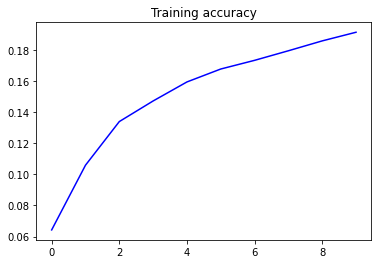

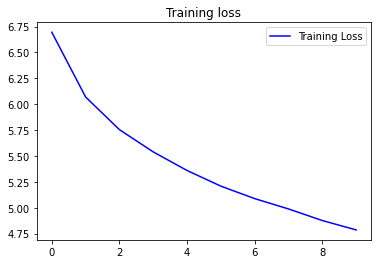

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [1]:
seed_text = "I'm Trump"
next_words = 100

In [2]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

NameError: name 'tokenizer' is not defined